In [1]:
'''
  A simple Conv3D example with TensorFlow 2 based Keras
'''
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical
#Used for 3D file extraction
import h5py
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout

In [2]:
!pwd
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

/content


In [3]:
! pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600  ~/.kaggle/kaggle.json
! kaggle datasets download -d daavoo/3d-mnist

 95% 145M/153M [00:04<00:00, 35.0MB/s]
100% 153M/153M [00:04<00:00, 34.0MB/s]


In [5]:
! unzip 3d-mnist.zip

Archive:  3d-mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


In [14]:
# -- Preparatory code --
# Model configuration
batch_size = 100
no_epochs = 100
learning_rate = 0.001
no_classes = 10
validation_split = 0.2
verbosity = 1

# Convert 1D vector into 3D values, provided by the 3D MNIST authors at
#Used for converting the channels from 1 to 3rgb
# https://www.kaggle.com/daavoo/3d-mnist
def array_to_color(array, cmap="Oranges"):
  s_m = plt.cm.ScalarMappable(cmap=cmap)
  return s_m.to_rgba(array)[:,:-1]

# Reshape data into format that can be handled by Conv3D layers.
# Courtesy of Sam Berglin; Zheming Lian; Jiahui Jang - University of Wisconsin-Madison
# Report - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/Report.pdf
# Code - https://github.com/sberglin/Projects-and-Papers/blob/master/3D%20CNN/network_final_version.ipynb
#Used for converting it into a 4d array with 1 being the channels rgb
def rgb_data_transform(data):
  data_t = []
  for i in range(data.shape[0]):
    data_t.append(array_to_color(data[i]).reshape(16, 16, 16, 3))
  return np.asarray(data_t, dtype=np.float32)


Epoch 1/100
80/80 [==============================] - 3s 30ms/step - loss: 3.0099 - accuracy: 0.1045 - val_loss: 2.3015 - val_accuracy: 0.1190
Epoch 2/100
80/80 [==============================] - 2s 26ms/step - loss: 2.3017 - accuracy: 0.1109 - val_loss: 2.2997 - val_accuracy: 0.1190
Epoch 3/100
80/80 [==============================] - 2s 27ms/step - loss: 2.3015 - accuracy: 0.1142 - val_loss: 2.2992 - val_accuracy: 0.1190
Epoch 4/100
80/80 [==============================] - 2s 26ms/step - loss: 2.3012 - accuracy: 0.1141 - val_loss: 2.2985 - val_accuracy: 0.1190
Epoch 5/100
80/80 [==============================] - 2s 26ms/step - loss: 2.3010 - accuracy: 0.1141 - val_loss: 2.2986 - val_accuracy: 0.1190
Epoch 6/100
80/80 [==============================] - 2s 26ms/step - loss: 2.3009 - accuracy: 0.1098 - val_loss: 2.2986 - val_accuracy: 0.1190
Epoch 7/100
80/80 [==============================] - 2s 28ms/step - loss: 2.3007 - accuracy: 0.1144 - val_loss: 2.2984 - val_accuracy: 0.1190
Epoch 

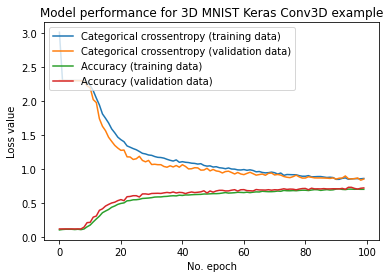

In [20]:

# -- Process code --
# Load the HDF5 data file
with h5py.File("./full_dataset_vectors.h5", "r") as hf:    

    # Split the data into training/test features/targets
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]

    # Determine sample shape
    sample_shape = (16, 16, 16, 3)

    # Reshape data into 3D format
    X_train = rgb_data_transform(X_train)
    X_test = rgb_data_transform(X_test)

    # Convert target vectors to categorical targets
    targets_train = to_categorical(targets_train).astype(np.int64)
    targets_test = to_categorical(targets_test).astype(np.int64)
    
    # Create the model
    model = Sequential()
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same', input_shape=sample_shape))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform',padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(no_classes, activation='softmax'))

    tensorflow.keras.backend.clear_session()
    # Compile the model
    model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                  optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])

    # Fit data to model
    history = model.fit(X_train, targets_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                validation_split=validation_split)

    # Generate generalization metrics
    score = model.evaluate(X_test, targets_test, verbose=0)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

    # Plot history: Categorical crossentropy & Accuracy
    plt.plot(history.history['loss'], label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'], label='Categorical crossentropy (validation data)')
    plt.plot(history.history['accuracy'], label='Accuracy (training data)')
    plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    plt.title('Model performance for 3D MNIST Keras Conv3D example')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()